In [106]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [107]:
def to_bit_str(val: int, num_of_bits: int):
    return f"{val:0{num_of_bits}b}"

# Person 1

In [108]:
# constants
PLAINTEXT_BITS = 16
MAX_VALUE = 1 << PLAINTEXT_BITS - 1
PLAINTEXT_NUM = 10000
FULL_ENCRYPTION_ROUNDS = 4 # NOTE: round 5 is simply key mixing

# variables
round_keys = [55382, 42954, 53122, 38368, 40273]

s_box = {
    0x0: 0xb,
    0x1: 0x7,
    0x2: 0x5,
    0x3: 0xf,
    0x4: 0x8,
    0x5: 0x9,
    0x6: 0x1,
    0x7: 0xe,
    0x8: 0x4,
    0x9: 0xa,
    0xa: 0x6,
    0xb: 0xd,
    0xc: 0x2,
    0xd: 0xc,
    0xe: 0x0,
    0xf: 0x3,
}

def permutation(bit_str_16: str) -> str:
    assert(len(bit_str_16) == PLAINTEXT_BITS)
    res = list(bit_str_16)
    for i in range(0, PLAINTEXT_BITS):
        # print(4 * (i % 4) + (i // 4)) # debug
        res[4 * (i % 4) + (i // 4)] = bit_str_16[i]
    # print(bit_str_16) # debug
    # print(''.join(res)) # debug
    return ''.join(res)

def encrypt_one_round(to_encrypt: int, k: int) -> str:
    # key mixing
    # print(to_encrypt, k) # debug
    to_encrypt ^= k
    # print(to_encrypt) # debug

    # 4-bit s-box
    PART_NUM_OF_BITS = 4
    NUM_OF_PARTS = PLAINTEXT_BITS / PART_NUM_OF_BITS
    parts = [] # index 0: least significant
    while to_encrypt > 0:
        parts.append(to_encrypt % (1 << PART_NUM_OF_BITS))
        to_encrypt //= 16
    while len(parts) < 4:
        parts.append(0)
    assert(len(parts) == NUM_OF_PARTS)
    parts.reverse()
    # print("before s-box:", parts) # debug
    for i in range(0, len(parts)):
        parts[i] = s_box[parts[i]]
    # print("after s-box:", parts) # debug
    bit_str_16 = ''.join(to_bit_str(x, PART_NUM_OF_BITS) for x in parts)
    # print(bit_str_16) # debug
    
    # permutation
    res = permutation(bit_str_16)
    # print(res) # debug
    return res

def full_encrypt(plaintext: int) -> int:
    # print(plaintext, f"{plaintext:0{PLAINTEXT_BITS}b}") # debug
    tmp = plaintext
    for i in range(0, FULL_ENCRYPTION_ROUNDS):
        tmp = int(encrypt_one_round(tmp, round_keys[i]), 2)
        # print(f"Round {i + 1}:") # debug
        # print(tmp, f"{tmp:0{PLAINTEXT_BITS}b}") # debug
    # last round: simple key mixing
    tmp ^= round_keys[FULL_ENCRYPTION_ROUNDS]
    # print(tmp, f"{tmp:0{PLAINTEXT_BITS}b}") # debug
    return tmp

In [109]:
# generate plaintext-ciphertext pairs that satisfy the chosen plaintext attack requirements
pc_paris = dict()
# chosen plaintext differentials
delta_p = int("0000111000000000", 2)
while len(pc_paris) < PLAINTEXT_NUM:
    plaintext = random.randint(0, MAX_VALUE)
    if plaintext in pc_paris.keys():
        continue
    pc_paris[plaintext] = full_encrypt(plaintext)
    pc_paris[plaintext ^ delta_p] = full_encrypt(plaintext ^ delta_p)
assert(len(pc_paris) == PLAINTEXT_NUM)
# print(pc_paris)

# Person 2

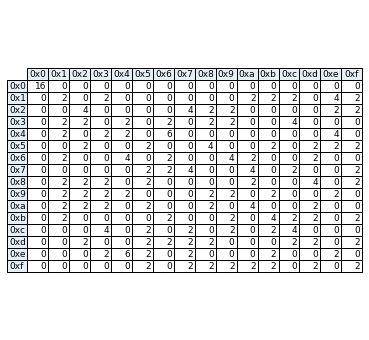

In [110]:
# compute s-box difference distribution table (Table 7)
diff_dist_table = [[0 for i in range(0, 16)] for j in range(0, 16)] # dimension 1: input diff; dimension 2: output diff
# print(diff_dist_table)
for x1 in range(0, 16):
    for x2 in range(0, 16):
        delta_x = x1 ^ x2
        # print(f"x1 = {x1}, x2 = {x2}, delta_x = {delta_x}")
        y1 = s_box[x1]
        y2 = s_box[x2]
        delta_y = y1 ^ y2
        # print(f"y1 = {y1}, y2 = {y2}, delta_y = {delta_y}\n")
        diff_dist_table[delta_x][delta_y] += 1
        # print(diff_dist_table)

headers=[hex(i) for i in range(0, 16)]
plt.figure(linewidth=2,
           figsize=(6, 6))
ax = plt.gca()
ax.axis("off")

rcolors = plt.cm.BuPu(np.full(len(headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(headers), 0.1))
table = plt.table(cellText=diff_dist_table,
                  rowLabels=headers,
                  rowColours=rcolors,
                  colLabels=headers,
                  colColours=rcolors,
                  loc="center")
plt.savefig("diff-distribution-tale.png", dpi=300)

In [111]:
reverse_s_box = dict((v, k) for k, v in s_box.items())
# make sure the reverse mapping is correct
for k, v in s_box.items():
    assert(reverse_s_box[v] == k)

def last_round_partial_decrypt(partial_key: int, partial_ciphertext: int) -> int:
    # reverse key mixing
    tmp = partial_ciphertext ^ partial_key
    # reverse s-box
    return reverse_s_box[tmp]

In [112]:
delta_u44_u47 = int("0110", 2) # NOTE: delta_u45_u48 in the figure 5
delta_u48_u411 = int("0110", 2) # NOTE: delta_u49_u412 in the figure 5

last_key = to_bit_str(round_keys[4], PLAINTEXT_BITS)
last_key_4_7 = last_key[4: 7+1]
last_key_8_11 = last_key[8: 11+1]
print(f"last_key={last_key}, last_key_4_7={last_key_4_7}, last_key_8_11={last_key_8_11}") # debug

# dimension 1: k55_k58; dimension 1: k59_k512
counter = dict()
# init
for k55_k58 in range(0, 16):
    for k59_k512 in range(0, 16):
        counter[(k55_k58, k59_k512)] = 0
# compute
for k55_k58 in range(0, 16):
    for k59_k512 in range(0, 16):
        # print(f"k55_k58={k55_k58}, k59_k512={k59_k512}") # debug
        for p, c in pc_paris.items():
            # partial decrypt the first one
            c_str = to_bit_str(c, PLAINTEXT_BITS)
            # print(f"c = {c}, c_str={c_str}, c_str[4: 7+1]={c_str[4: 7+1]}, c_str[8: 11+1]={c_str[8: 11+1]}") # debug
            rc_44_47 = last_round_partial_decrypt(k55_k58, int(c_str[4: 7+1], 2))
            rc_48_411 = last_round_partial_decrypt(k59_k512, int(c_str[8: 11+1], 2))

            # partial decrypt the second one
            pp = p ^ delta_p
            assert(pp in pc_paris.keys())
            cc = pc_paris[pp]
            cc_str = to_bit_str(cc, PLAINTEXT_BITS)
            # print(f"cc = {cc}, c_str={cc_str}, cc_str[4: 7+1]={cc_str[4: 7+1]}, cc_str[8: 11+1]={cc_str[8: 11+1]}") # debug
            rcc_44_47 = last_round_partial_decrypt(k55_k58, int(cc_str[4: 7+1], 2))
            rcc_48_411 = last_round_partial_decrypt(k59_k512, int(cc_str[8: 11+1], 2))

            # calculate the diff
            diff_44_47 = rc_44_47 ^ rcc_44_47
            diff_48_411 = rc_48_411 ^ rcc_48_411
            if (diff_44_47 == delta_u44_u47) and (diff_48_411 == delta_u48_u411):
                counter[(k55_k58, k59_k512)] += 1

# sort the dict by values in the descending order
# sorted_counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
print(counter)

last_key=1001110101010001, last_key_4_7=1101, last_key_8_11=0101
{(0, 0): 40, (0, 1): 32, (0, 2): 42, (0, 3): 24, (0, 4): 38, (0, 5): 22, (0, 6): 54, (0, 7): 36, (0, 8): 40, (0, 9): 34, (0, 10): 50, (0, 11): 46, (0, 12): 52, (0, 13): 38, (0, 14): 52, (0, 15): 48, (1, 0): 26, (1, 1): 42, (1, 2): 48, (1, 3): 50, (1, 4): 40, (1, 5): 44, (1, 6): 32, (1, 7): 42, (1, 8): 48, (1, 9): 64, (1, 10): 50, (1, 11): 78, (1, 12): 46, (1, 13): 68, (1, 14): 36, (1, 15): 54, (2, 0): 54, (2, 1): 36, (2, 2): 58, (2, 3): 42, (2, 4): 36, (2, 5): 36, (2, 6): 52, (2, 7): 40, (2, 8): 64, (2, 9): 38, (2, 10): 56, (2, 11): 30, (2, 12): 50, (2, 13): 30, (2, 14): 40, (2, 15): 30, (3, 0): 36, (3, 1): 48, (3, 2): 46, (3, 3): 56, (3, 4): 42, (3, 5): 46, (3, 6): 26, (3, 7): 30, (3, 8): 50, (3, 9): 52, (3, 10): 36, (3, 11): 48, (3, 12): 46, (3, 13): 50, (3, 14): 40, (3, 15): 36, (4, 0): 42, (4, 1): 38, (4, 2): 54, (4, 3): 30, (4, 4): 52, (4, 5): 38, (4, 6): 50, (4, 7): 44, (4, 8): 48, (4, 9): 34, (4, 10): 50, (4, 11): 